In [ ]:
!pip install tslearn icecream

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.2 MB/s eta 0:00:00


In [28]:
from icecream import ic
import numpy as np
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Generate synthetic data for person distance from home
n_ts, sz = 1000, 10  # Number of time series 1k and size is 10 timesteps

# Make 4 time-series features
# Scale the data
scaler1 = TimeSeriesScalerMeanVariance(mu=0., std=1.)
dataset_0 = np.abs(scaler1.fit_transform(np.random.rand(n_ts, sz, 4))) # we now have a population that stays near home
scaler2 = TimeSeriesScalerMeanVariance(mu=0.4, std=.8)
dataset_1 = np.abs(scaler2.fit_transform(np.random.rand(n_ts, sz, 4))) # we now have a population that ventures a bit farther from home

# Create labels
labels_0 = np.zeros(n_ts) # close to home people
labels_1 = np.ones(n_ts) # wanderers

# Combine data and labels

X_train = np.concatenate((dataset_0[:int(0.8*n_ts),             :,:], dataset_1[:int(0.8*n_ts),             :,:]), axis=0)
X_val   = np.concatenate((dataset_0[int(0.8*n_ts):int(0.9*n_ts),:,:], dataset_1[int(0.8*n_ts):int(0.9*n_ts),:,:]), axis=0)
X_test  = np.concatenate((dataset_0[int(0.9*n_ts):,             :,:], dataset_1[int(0.9*n_ts):,             :,:]), axis=0)

y_train = np.concatenate((labels_0[:int(0.8*n_ts)], labels_1[:int(0.8*n_ts)]), axis=0)
y_val   = np.concatenate((labels_0[int(0.8*n_ts):int(0.9*n_ts)], labels_1[int(0.8*n_ts):int(0.9*n_ts)]), axis=0)
y_test  = np.concatenate((labels_0[int(0.9*n_ts):], labels_1[int(0.9*n_ts):]), axis=0)

ic(X_train.shape, y_train.shape,X_val.shape, y_val.shape,X_test.shape, y_test.shape) # check the shape
print(X_train[0]) # check the first data point
print(y_train[0]) # check its label

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The TimeSeriesScalerMeanVariance or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: 

[[0.96394311 1.53943707 0.9370623  1.76419492]
 [0.46217335 0.44362163 0.2847139  0.21166744]
 [0.50438814 0.75196408 1.03390309 0.86750673]
 [0.37984666 0.81343911 1.49529567 0.09450967]
 [0.96504355 1.73049135 0.81235256 1.22312786]
 [1.40699726 1.49414426 1.17806469 0.05415794]
 [0.53134106 0.83840677 1.00982493 1.50927279]
 [1.33005095 0.17761676 0.66841074 0.31166638]
 [1.74399509 0.39503778 0.01299411 1.17443944]
 [0.67430742 0.29766475 1.49048525 0.90993957]]
0.0


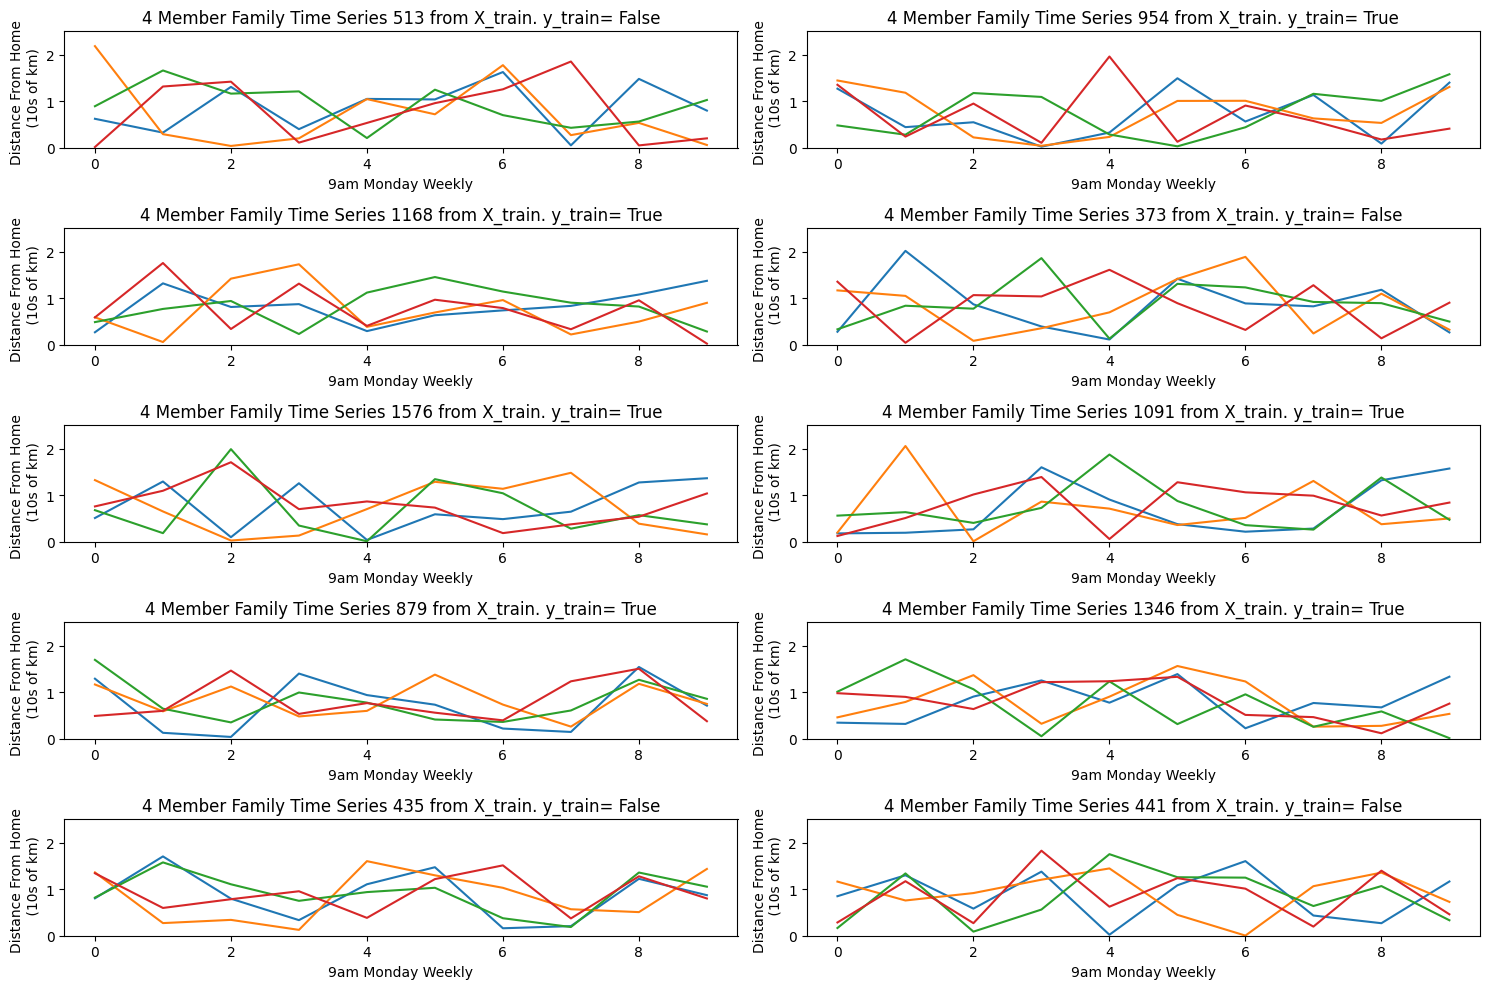

In [50]:
import matplotlib.pyplot as plt
import random

# X_train is 3D with shape (samples, time_steps, features)
# y_train is a 1D array

samps = X_train.shape[0] # Number of samples to plot
indices = random.sample(range(samps), 10)  # Select 10 random samples

# Create a single figure with multiple subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 10))  # Adjust rows and columns as needed
axes = axes.flatten()  # Flatten to easily iterate

for ax, i in zip(axes, indices):
    ax.plot(X_train[i, :, :])  # Plotting the first feature of the time series
    ax.set_title(f"4 Member Family Time Series {i} from X_train. y_train= {1 == y_train[i]}")
    ax.set_xlabel("9am Monday Weekly")
    ax.set_ylabel("Distance From Home \n (10s of km)")
    ax.set_ylim(0, 2.5)  # Set y-axis range

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [40]:
import random

# make a generic generator
def datagen(samples,labels):
  while True:
    for i in random.sample(range(len(samples)),len(samples)):
      yield (tf.constant(samples[i][np.newaxis,:,:], dtype=tf.float16),tf.constant([labels[i]], dtype=tf.float16))

# make generator instances
train_gen = datagen(X_train,y_train)
val_gen = datagen(X_val,y_val)
test_gen = datagen(X_test,y_test)
next(train_gen),next(train_gen),next(train_gen)

((<tf.Tensor: shape=(1, 10, 4), dtype=float16, numpy=
  array([[[0.5786  , 1.923   , 0.302   , 0.5005  ],
          [0.9243  , 1.368   , 0.0933  , 0.373   ],
          [0.9087  , 0.013336, 0.1583  , 0.2     ],
          [1.082   , 0.0196  , 0.663   , 1.3955  ],
          [0.1859  , 0.4307  , 0.8877  , 0.1065  ],
          [0.1473  , 0.02504 , 0.4417  , 1.732   ],
          [1.603   , 0.4617  , 1.566   , 0.2266  ],
          [0.5073  , 0.52    , 1.197   , 0.222   ],
          [1.067   , 1.05    , 1.55    , 0.1344  ],
          [0.891   , 0.811   , 0.4028  , 1.578   ]]], dtype=float16)>,
  <tf.Tensor: shape=(1,), dtype=float16, numpy=array([1.], dtype=float16)>),
 (<tf.Tensor: shape=(1, 10, 4), dtype=float16, numpy=
  array([[[1.963  , 0.5093 , 1.42   , 0.923  ],
          [0.3738 , 0.7524 , 1.23   , 1.97   ],
          [0.559  , 1.419  , 0.1119 , 0.1904 ],
          [0.2808 , 0.9507 , 0.284  , 0.6875 ],
          [0.114  , 0.0393 , 1.81   , 1.26   ],
          [1.375  , 1.434  , 0.9155 

In [42]:
# Data for LSTM input (samples, timesteps, features)
#X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_gen, epochs=15, batch_size=16,validation_data=val_gen, steps_per_epoch=100,validation_batch_size=8, validation_steps=25) #
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

# Make predictions
predictions = model.predict(X_test)
#[((p[0]>.5)==(y_t==1)) for p,y_t in zip(predictions,y_test)]

Epoch 1/15
100/100 [==============================] - 3s 11ms/step - loss: 0.7009 - accuracy: 0.5100 - val_loss: 0.6931 - val_accuracy: 0.5200
Epoch 2/15
100/100 [==============================] - 1s 6ms/step - loss: 0.6947 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4400
Epoch 3/15
100/100 [==============================] - 1s 6ms/step - loss: 0.6835 - accuracy: 0.5900 - val_loss: 0.6832 - val_accuracy: 0.5200
Epoch 4/15
100/100 [==============================] - 1s 6ms/step - loss: 0.6832 - accuracy: 0.5200 - val_loss: 0.6882 - val_accuracy: 0.4800
Epoch 5/15
100/100 [==============================] - 1s 6ms/step - loss: 0.6873 - accuracy: 0.5200 - val_loss: 0.6803 - val_accuracy: 0.4800
Epoch 6/15
100/100 [==============================] - 1s 6ms/step - loss: 0.6946 - accuracy: 0.4400 - val_loss: 0.6700 - val_accuracy: 0.6000
Epoch 7/15
100/100 [==============================] - 1s 6ms/step - loss: 0.6869 - accuracy: 0.5000 - val_loss: 0.6823 - val_accuracy: 0.5600
Epoch

In [43]:
from sklearn.metrics import classification_report

# Convert probabilities to class labels (0 or 1)
predicted_labels = (predictions > 0.5).astype(int)

# Generate the classification report
report = classification_report(y_test, predicted_labels)

print(report)

              precision    recall  f1-score   support

         0.0       0.79      0.99      0.88       100
         1.0       0.99      0.73      0.84       100

    accuracy                           0.86       200
   macro avg       0.89      0.86      0.86       200
weighted avg       0.89      0.86      0.86       200

